In [ ]:
#from https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/

import pandas as pd
import seaborn as sns
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import pickle
df = pd.read_csv("../PreProcessamentoDados/cleanedData.csv")

In [ ]:
df[['Hour','Minute','Second']] = df.DateTime.str.split(":",expand=True)

In [ ]:
df.head()

In [ ]:
df.dtypes

In [ ]:
# define a dictionary of column names and their corresponding data types
dtypes_dict = {'Hour': float, 'Minute': float}

# convert the columns to their corresponding data types
df = df.astype(dtypes_dict)

In [ ]:
df.head()

In [93]:
# Separate Target Variable and Predictor Variables
TargetVariable = ["Generated power"]
Predictors= ["Hour","Minute","TemperatureC","DewpointC","PressurehPa","WindDirectionDegrees","WindSpeedKMH","WindSpeedGustKMH","Humidity","HourlyPrecipMM","dailyrainMM","SolarRadiationWatts_m2"]

X=df[Predictors].values
y=df[TargetVariable].values

In [ ]:
# check if the array has any negative values
if (y < 0).any():
    print('The array has negative values.')
else:
    print('The array does not have negative values.')

In [ ]:
# y = df['generated_power'].values
# X = df.drop(columns=['generated_power']).values

In [ ]:
# y = y.reshape(-1,1)


In [94]:
### Standardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)


In [ ]:
### Standardization of data ###
from sklearn.preprocessing import MinMaxScaler
PredictorScaler=MinMaxScaler()
TargetVarScaler=MinMaxScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)


In [95]:
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 

In [ ]:
# check if the array has any negative values
if (y < 0).any():
    print('The array has negative values.')
else:
    print('The array does not have negative values.')

In [96]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(44351, 12)
(44351, 1)
(19008, 12)
(19008, 1)


In [98]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=12, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

In [99]:

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_error'])

In [ ]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

# Hyperparameter tuning of ANN


# Finding best set of parameters using manual grid search


In [100]:
import numpy as np

# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_error'])

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=1)

            mean_squared_error, mean_absolute_error = model.evaluate(X_test,y_test)

            # print("y_test: ",y_test)
            predictions = model.predict(X_test)
            # print("model.predict(X_test)",predictions)
            MAPE = np.mean(100 * (np.abs(y_test-predictions)/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'MAPE:',MAPE,'Accuracy:', 100-MAPE,'mean_squared_error: ',mean_squared_error,
                  'mean_absolute_error: ',mean_absolute_error)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy','mean_squared_error','mean_absolute_error'] ))
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

Epoch 1/5
8871/8871 [==============================] - 14s 2ms/step - loss: 0.2025 - mean_absolute_error: 0.2564
Epoch 2/5
8871/8871 [==============================] - 13s 2ms/step - loss: 0.1421 - mean_absolute_error: 0.2104
Epoch 3/5
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1373 - mean_absolute_error: 0.2005
Epoch 4/5
8871/8871 [==============================] - 16s 2ms/step - loss: 0.1359 - mean_absolute_error: 0.1986
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
1 Parameters: batch_size: 5 - epochs: 5 MAPE: 62.93221737011823 Accuracy: 37.06778262988177 mean_squared_error:  0.1314605325460434 mean_absolute_error:  0.19787441194057465
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 18s 2ms/step - loss: 0.2104 - mean_absolute_error: 0.2654
Epoch 2/10
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1663 - mean_absolute_error: 0.2341
Epoch 3/10
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1563 - mean_absolute_error: 0.2202
Epoch 4/10
8871/8871 [==============================] - 19s 2ms/step - loss: 0.1529 - mean_absolute_error: 0.2158
Epoch 5/10
8871/8871 [==============================] - 14s 2ms/step - loss: 0.1521 - mean_absolute_error: 0.2143
Epoch 6/10
8871/8871 [==============================] - 14s 2ms/step - loss: 0.1513 - mean_absolute_error: 0.2138
Epoch 7/10
8871/8871 [==============================] - 18s 2ms/step - loss: 0.1509 - mean_absolute_error: 0.2146
Epoch 8/10
8871/8871 [==============================] - 14s 2ms/step - loss: 0.1502 - mean_absolute_error: 0.2142
Epoch 9/10
8871/8871 [==============================] - 13s 2ms/step - loss: 0.1483 - mean_absolute

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 14s 2ms/step - loss: 0.1945 - mean_absolute_error: 0.2520
Epoch 2/50
8871/8871 [==============================] - 14s 2ms/step - loss: 0.1437 - mean_absolute_error: 0.2101
Epoch 3/50
8871/8871 [==============================] - 13s 2ms/step - loss: 0.1361 - mean_absolute_error: 0.2019
Epoch 4/50
8871/8871 [==============================] - 12s 1ms/step - loss: 0.1336 - mean_absolute_error: 0.1989
Epoch 5/50
8871/8871 [==============================] - 12s 1ms/step - loss: 0.1323 - mean_absolute_error: 0.1970
Epoch 6/50
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1316 - mean_absolute_error: 0.1959
Epoch 7/50
8871/8871 [==============================] - 19s 2ms/step - loss: 0.1310 - mean_absolute_error: 0.1965
Epoch 8/50
8871/8871 [==============================] - 21s 2ms/step - loss: 0.1307 - mean_absolute_error: 0.1945
Epoch 9/50
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1299 - mean_absolute

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 17s 2ms/step - loss: 0.2060 - mean_absolute_error: 0.2618
Epoch 2/100
8871/8871 [==============================] - 18s 2ms/step - loss: 0.1452 - mean_absolute_error: 0.2122
Epoch 3/100
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1387 - mean_absolute_error: 0.2025
Epoch 4/100
8871/8871 [==============================] - 16s 2ms/step - loss: 0.1371 - mean_absolute_error: 0.2013
Epoch 5/100
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1362 - mean_absolute_error: 0.1994
Epoch 6/100
8871/8871 [==============================] - 16s 2ms/step - loss: 0.1360 - mean_absolute_error: 0.1987
Epoch 7/100
8871/8871 [==============================] - 17s 2ms/step - loss: 0.1354 - mean_absolute_error: 0.1984
Epoch 8/100
8871/8871 [==============================] - 18s 2ms/step - loss: 0.1355 - mean_absolute_error: 0.1983
Epoch 9/100
8871/8871 [==============================] - 18s 2ms/step - loss: 0.1346 - mean_

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 8s 2ms/step - loss: 0.3736 - mean_absolute_error: 0.3241
Epoch 2/5
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1696 - mean_absolute_error: 0.2248
Epoch 3/5
4436/4436 [==============================] - 7s 1ms/step - loss: 0.1475 - mean_absolute_error: 0.2105
Epoch 4/5
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1431 - mean_absolute_error: 0.2118
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
5 Parameters: batch_size: 10 - epochs: 5 MAPE: 78.23996372769771 Accuracy: 21.760036272302287 mean_squared_error:  0.14082005620002747 mean_absolute_error:  0.20789426565170288
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 9s 2ms/step - loss: 0.2103 - mean_absolute_error: 0.2572
Epoch 2/10
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1427 - mean_absolute_error: 0.2090
Epoch 3/10
4436/4436 [==============================] - 10s 2ms/step - loss: 0.1365 - mean_absolute_error: 0.2005
Epoch 4/10
4436/4436 [==============================] - 9s 2ms/step - loss: 0.1338 - mean_absolute_error: 0.1954
Epoch 5/10
4436/4436 [==============================] - 9s 2ms/step - loss: 0.1323 - mean_absolute_error: 0.1930
Epoch 6/10
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1313 - mean_absolute_error: 0.1922
Epoch 7/10
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1306 - mean_absolute_error: 0.1908
Epoch 8/10
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1302 - mean_absolute_error: 0.1911
Epoch 9/10
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1297 - mean_absolute_error: 

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 10s 2ms/step - loss: 0.2062 - mean_absolute_error: 0.2640
Epoch 2/50
4436/4436 [==============================] - 9s 2ms/step - loss: 0.1411 - mean_absolute_error: 0.2050
Epoch 3/50
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1349 - mean_absolute_error: 0.1990
Epoch 4/50
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1325 - mean_absolute_error: 0.1963
Epoch 5/50
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1310 - mean_absolute_error: 0.1942
Epoch 6/50
4436/4436 [==============================] - 10s 2ms/step - loss: 0.1303 - mean_absolute_error: 0.1937
Epoch 7/50
4436/4436 [==============================] - 9s 2ms/step - loss: 0.1297 - mean_absolute_error: 0.1927
Epoch 8/50
4436/4436 [==============================] - 8s 2ms/step - loss: 0.1296 - mean_absolute_error: 0.1930
Epoch 9/50
4436/4436 [==============================] - 7s 2ms/step - loss: 0.1290 - mean_absolute_error:

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 7s 1ms/step - loss: 0.2283 - mean_absolute_error: 0.2737
Epoch 2/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1610 - mean_absolute_error: 0.2253
Epoch 3/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1472 - mean_absolute_error: 0.2144
Epoch 4/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1418 - mean_absolute_error: 0.2108
Epoch 5/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1386 - mean_absolute_error: 0.2077
Epoch 6/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1367 - mean_absolute_error: 0.2053
Epoch 7/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1355 - mean_absolute_error: 0.2044
Epoch 8/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1350 - mean_absolute_error: 0.2032
Epoch 9/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1345 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 5s 2ms/step - loss: 0.2282 - mean_absolute_error: 0.2796
Epoch 2/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1506 - mean_absolute_error: 0.2155
Epoch 3/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1394 - mean_absolute_error: 0.2060
Epoch 4/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1352 - mean_absolute_error: 0.2011
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
9 Parameters: batch_size: 15 - epochs: 5 MAPE: 71.76540795779961 Accuracy: 28.23459204220039 mean_squared_error:  0.13179665803909302 mean_absolute_error:  0.19290637969970703
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 5s 2ms/step - loss: 0.2677 - mean_absolute_error: 0.3409
Epoch 2/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1829 - mean_absolute_error: 0.2510
Epoch 3/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1774 - mean_absolute_error: 0.2431
Epoch 4/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1672 - mean_absolute_error: 0.2264
Epoch 5/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1601 - mean_absolute_error: 0.2163
Epoch 6/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1537 - mean_absolute_error: 0.2111
Epoch 7/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1460 - mean_absolute_error: 0.2030
Epoch 8/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1402 - mean_absolute_error: 0.1968
Epoch 9/10
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1371 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 5s 2ms/step - loss: 0.2415 - mean_absolute_error: 0.2814
Epoch 2/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1578 - mean_absolute_error: 0.2356
Epoch 3/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1504 - mean_absolute_error: 0.2322
Epoch 4/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1439 - mean_absolute_error: 0.2227
Epoch 5/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1392 - mean_absolute_error: 0.2122
Epoch 6/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1368 - mean_absolute_error: 0.2061
Epoch 7/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1349 - mean_absolute_error: 0.2031
Epoch 8/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1342 - mean_absolute_error: 0.2004
Epoch 9/50
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1334 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 5s 2ms/step - loss: 0.2353 - mean_absolute_error: 0.2810
Epoch 2/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1499 - mean_absolute_error: 0.2210
Epoch 3/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1399 - mean_absolute_error: 0.2101
Epoch 4/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1356 - mean_absolute_error: 0.2039
Epoch 5/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1334 - mean_absolute_error: 0.2000
Epoch 6/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1320 - mean_absolute_error: 0.1973
Epoch 7/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1307 - mean_absolute_error: 0.1948
Epoch 8/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1297 - mean_absolute_error: 0.1929
Epoch 9/100
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1297 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 4s 2ms/step - loss: 0.2558 - mean_absolute_error: 0.2967
Epoch 2/5
2218/2218 [==============================] - 3s 2ms/step - loss: 0.1522 - mean_absolute_error: 0.2206
Epoch 3/5
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1439 - mean_absolute_error: 0.2141
Epoch 4/5
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1393 - mean_absolute_error: 0.2098
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
13 Parameters: batch_size: 20 - epochs: 5 MAPE: 61.77591304898514 Accuracy: 38.22408695101486 mean_squared_error:  0.13383598625659943 mean_absolute_error:  0.19924724102020264
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 5s 2ms/step - loss: 0.2563 - mean_absolute_error: 0.3022
Epoch 2/10
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1619 - mean_absolute_error: 0.2293
Epoch 3/10
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1478 - mean_absolute_error: 0.2103
Epoch 4/10
2218/2218 [==============================] - 5s 2ms/step - loss: 0.1391 - mean_absolute_error: 0.2037
Epoch 5/10
2218/2218 [==============================] - 5s 2ms/step - loss: 0.1350 - mean_absolute_error: 0.2004
Epoch 6/10
2218/2218 [==============================] - 7s 3ms/step - loss: 0.1324 - mean_absolute_error: 0.1970
Epoch 7/10
2218/2218 [==============================] - 5s 2ms/step - loss: 0.1310 - mean_absolute_error: 0.1946
Epoch 8/10
2218/2218 [==============================] - 3s 2ms/step - loss: 0.1300 - mean_absolute_error: 0.1930
Epoch 9/10
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1294 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 4s 2ms/step - loss: 0.2742 - mean_absolute_error: 0.2956
Epoch 2/50
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1608 - mean_absolute_error: 0.2301
Epoch 3/50
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1471 - mean_absolute_error: 0.2171
Epoch 4/50
2218/2218 [==============================] - 3s 2ms/step - loss: 0.1418 - mean_absolute_error: 0.2101
Epoch 5/50
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1396 - mean_absolute_error: 0.2060
Epoch 6/50
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1372 - mean_absolute_error: 0.2007
Epoch 7/50
2218/2218 [==============================] - 3s 2ms/step - loss: 0.1359 - mean_absolute_error: 0.1980
Epoch 8/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1347 - mean_absolute_error: 0.1962
Epoch 9/50
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1342 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 4s 2ms/step - loss: 0.2451 - mean_absolute_error: 0.2910
Epoch 2/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1592 - mean_absolute_error: 0.2256
Epoch 3/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1457 - mean_absolute_error: 0.2119
Epoch 4/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1392 - mean_absolute_error: 0.2064
Epoch 5/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1352 - mean_absolute_error: 0.2015
Epoch 6/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1323 - mean_absolute_error: 0.1964
Epoch 7/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1314 - mean_absolute_error: 0.1942
Epoch 8/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1301 - mean_absolute_error: 0.1931
Epoch 9/100
2218/2218 [==============================] - 4s 2ms/step - loss: 0.1296 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_15388\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


<AxesSubplot:xlabel='Parameters'>

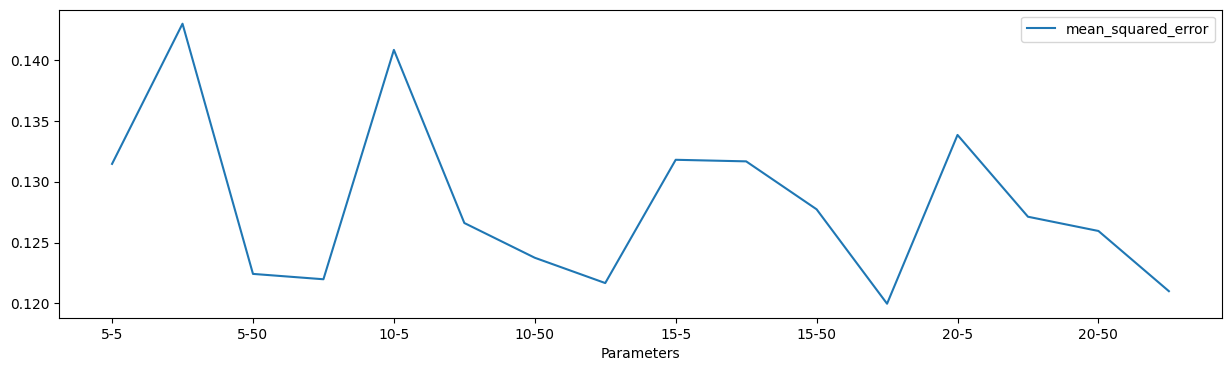

In [101]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='mean_squared_error',figsize=(15,4), kind='line')

In [102]:
ResultsData

,TrialNumber,Parameters,Accuracy,mean_squared_error,mean_absolute_error
0,1,5-5,37.067783,0.131461,0.197874
0,2,5-10,20.854823,0.142969,0.213119
0,3,5-50,36.364611,0.122427,0.182112
0,4,5-100,44.465313,0.121987,0.183105
0,5,10-5,21.760036,0.140820,0.207894
0,6,10-10,37.209010,0.126606,0.185005
0,7,10-50,29.962894,0.123752,0.196766
0,8,10-100,33.355337,0.121674,0.185675
0,9,15-5,28.234592,0.131797,0.192906
0,10,15-10,49.068066,0.131667,0.191551


<AxesSubplot:xlabel='Parameters'>

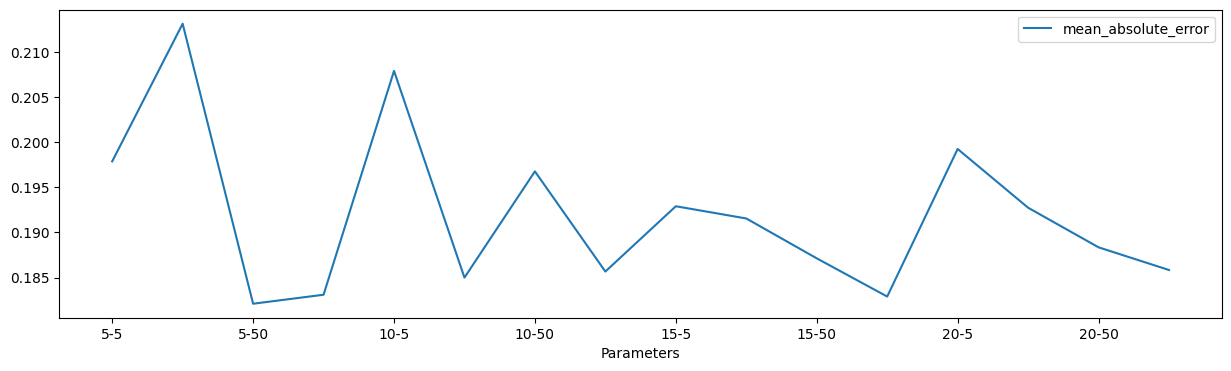

In [103]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='mean_absolute_error',figsize=(15,4), kind='line')

In [ ]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

In [ ]:

# importing package
import matplotlib.pyplot as plt
import numpy as np

x = ResultsData["Parameters"]  

# plot lines
plt.plot(x, ResultsData["mean_squared_error"], label = "mean squared")
plt.plot(ResultsData["Parameters"], ResultsData["mean_absolute_error"], label = "mean absolute")
plt.legend()
plt.show()

In [ ]:
ResultsData

In [ ]:
ResultsData.to_csv('ResultsData.csv', index=False)

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame with custom options
LoadedResultsData = pd.read_csv('ResultsData.csv', delimiter=',', encoding='utf-8', header=0, names=['TrialNumber','Parameters','Accuracy','mean_squared_error','mean_absolute_error'])

# Display the DataFrame
print(LoadedResultsData)


In [ ]:
%matplotlib inline
LoadedResultsData.plot(x='Parameters', y='mean_squared_error',figsize=(15,4), kind='line')

In [ ]:
%matplotlib inline
LoadedResultsData.plot(x='Parameters', y='mean_absolute_error',figsize=(15,4), kind='line')

In [ ]:
ResultsDataPlot = ResultsData


In [ ]:
ResultsDataPlot

In [ ]:
ResultsDataPlot["Accuracy"] = ResultsDataPlot["Accuracy"].add(100)

In [ ]:
ResultsDataPlot["Accuracy"] = ResultsDataPlot["Accuracy"].multiply(-1)


In [ ]:
ResultsDataPlot

In [ ]:
%matplotlib inline
ResultsDataPlot.plot(x='Parameters', y='mean_squared_error', figsize=(15,4), kind='line')

# Training the ANN model with the best parameters


In [105]:
# Fitting the ANN to the Training set
#  batch_size = 15, 
#    epochs = 5,
history=model.fit(
    X_train, 
    y_train ,
    batch_size = 15, 
    epochs = 100,     
    verbose=1,
    validation_split = 0.33)

Epoch 1/100
1981/1981 [==============================] - 3s 2ms/step - loss: 0.1228 - mean_absolute_error: 0.1838 - val_loss: 0.1240 - val_mean_absolute_error: 0.1865
Epoch 2/100
1981/1981 [==============================] - 4s 2ms/step - loss: 0.1232 - mean_absolute_error: 0.1850 - val_loss: 0.1172 - val_mean_absolute_error: 0.1846
Epoch 3/100
1981/1981 [==============================] - 4s 2ms/step - loss: 0.1229 - mean_absolute_error: 0.1841 - val_loss: 0.1176 - val_mean_absolute_error: 0.1805
Epoch 4/100
1981/1981 [==============================] - 4s 2ms/step - loss: 0.1226 - mean_absolute_error: 0.1843 - val_loss: 0.1167 - val_mean_absolute_error: 0.1811
Epoch 5/100
1981/1981 [==============================] - 3s 2ms/step - loss: 0.1227 - mean_absolute_error: 0.1843 - val_loss: 0.1167 - val_mean_absolute_error: 0.1781
Epoch 6/100
1981/1981 [==============================] - 3s 2ms/step - loss: 0.1223 - mean_absolute_error: 0.1840 - val_loss: 0.1187 - val_mean_absolute_error: 0.189

In [106]:
mean_squared_error, mean_absolute_error = model.evaluate(X_test,y_test)
print("MSE: ",mean_squared_error)
print("MAE:" ,mean_absolute_error)

594/594 [==============================] - 1s 2ms/step - loss: 0.1230 - mean_absolute_error: 0.1754
MSE:  0.12295647710561752
MAE: 0.17541764676570892


In [107]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)

594/594 [==============================] - 1s 1ms/step


In [108]:
from sklearn.metrics import r2_score
r2_score(y_test,Predictions)

0.8762401584492724

In [109]:


# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Generation']=y_test_orig
TestingData['PredictedGeneration']=Predictions
TestingData.head()

,Hour,Minute,TemperatureC,DewpointC,PressurehPa,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Generation,PredictedGeneration
0,15.0,45.0,26.333333,15.666667,1015.0,306.000000,12.333333,27.000000,51.666667,0.0,0.0,710.666667,2065.333333,2527.864258
1,2.0,0.0,19.000000,16.000000,1016.0,196.000000,0.000000,0.000000,83.000000,0.0,0.0,0.000000,0.000000,14.711179
2,5.0,45.0,19.000000,10.000000,1011.0,98.000000,6.333333,17.000000,56.000000,0.0,0.0,0.000000,0.000000,28.712032
3,13.0,45.0,27.333333,16.000000,1017.0,285.666667,0.333333,13.333333,49.333333,0.0,0.0,824.666667,5071.333333,4608.029785
4,19.0,30.0,18.000000,15.000000,1014.0,180.333333,1.000000,11.000000,82.666667,0.0,0.0,0.000000,0.000000,82.168396


In [ ]:
df_temp = pd.DataFrame({'Actual': y_test_orig, 'Predicted': Predictions})
df_temp.head()

In [ ]:
TestingData

# Save and Evaluation

In [110]:
filename = './DNN_finalized_model'


In [111]:
# save the model to disk
model.save(filename)

INFO:tensorflow:Assets written to: ./DNN_finalized_model\assets


In [112]:
import tensorflow as tf

# load the model from disk
model = tf.keras.models.load_model(filename)

In [113]:
print(type(model))

<class 'keras.engine.sequential.Sequential'>


In [ ]:
# Fitting the ANN to the Training set
history=model.fit(
    X_train,
    y_train, 
    batch_size = 15,
    epochs = 100,
    verbose=1,
    validation_split = 0.33)


In [ ]:

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Generation']=y_test_orig
TestingData['PredictedGeneration']=Predictions
TestingData.head()

In [ ]:
model.summary()

# Explainable AI Shap

In [ ]:
import shap
explainer = shap.DeepExplainer(model,X_train)

shap_values = explainer.shap_values(X_train)

In [ ]:
import shap
explainer = shap.DeepExplainer(model,X_test)

shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
from pprint import pprint

pprint(shap_values)

In [ ]:
import pickle
pickle.dump(shap_values, open("shap_values.bin", "wb"))

In [ ]:
import pickle
matrix = pickle.load(open("shap_values.bin", "rb"))

In [ ]:
import shap
shap.summary_plot(matrix,X_test)

In [ ]:
matrix

In [ ]:
with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,                        ):
    print(matrix)

In [ ]:
print(shap.__version__)
print(tf.__version__)


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)